# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Наша задача - обучить модель классифицировать комментарии на позитивные и негативные. В нашем распоряжении набор данных с разметкой о токсичности правок.

Мы должны построить модель со значением метрики качества *F1* не меньше 0.75.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Подготовка

In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, confusion_matrix
import lightgbm as lgb
from sklearn.pipeline import Pipeline

from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sanchezdoto\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
data = pd.read_csv('toxic_comments.csv')

In [3]:
data.head()

,Unnamed: 0,text,toxic
0,0,Explanation\nWhy the edits made under my usern...,0
1,1,D'aww! He matches this background colour I'm s...,0
2,2,"Hey man, I'm really not trying to edit war. It...",0
3,3,"""\nMore\nI can't make any real suggestions on ...",0
4,4,"You, sir, are my hero. Any chance you remember...",0


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ MB


In [5]:
data = data.drop('Unnamed: 0', axis=1)

Убрали ложный индекс.

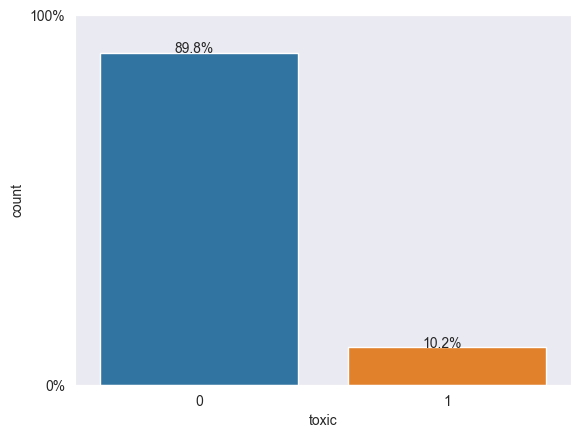

In [6]:
ax = sns.countplot(x='toxic', data=data)
total = float(len(data))
for p in ax.patches:
    height = p.get_height()
    percentage = '{:.1f}%'.format((height / total) * 100)
    x, y = p.get_xy()
    ax.annotate(percentage, (x + 0.3, y + height + 0.5))

plt.yticks([0, total], ['0%', '100%'])
plt.show()

Доля токсичных комментариев составила 10.2 процентов. Нами было принято решение не производить балансировку классов.

In [7]:
X = data['text']
y = data['toxic']

In [8]:
stop_words = set(stopwords.words('english'))
stemmer = nltk.SnowballStemmer('english')

def preprocess_text(text):
    text = re.sub(r'[^\w\s]', '', text)
    text = text.lower()
    words = text.split()
    words = [word for word in words if word not in stop_words]
    words = [stemmer.stem(word) for word in words]
    return ' '.join(words)

X = X.apply(preprocess_text)

Леммизировали предложения.

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=222)

Разбили фичи и таргеты.

## Обучение

In [10]:
def train_logistic(train_features, train_target, c, max_iter):
    pipeline = Pipeline([
        ('tfidf', TfidfVectorizer()),
        ('logistic', LogisticRegression())
    ])

    params = {'tfidf__max_df': [0.9, 0.95],
              'logistic__C': c,
              'logistic__max_iter': max_iter}

    search = HalvingGridSearchCV(pipeline, params, scoring='f1', n_jobs=-1, cv=5, factor=2, random_state=222)
    search.fit(train_features, train_target)

    return search.best_params_, search.best_score_, search.best_estimator_

In [11]:
%%time
logic_param, logic_score, logic_bm = train_logistic(X_train, y_train, np.arange(0.1, 10.1, 0.5), np.arange(500, 3500, 500))
print(f"Лучшие параметры для логистической регрессии (обучающая выборка): {logic_param}")
print(f"Лучшая точность для логистической регрессии (обучающая выборка): {logic_score}")

Лучшие параметры для логистической регрессии (обучающая выборка): {'logistic__C': 9.6, 'logistic__max_iter': 1000, 'tfidf__max_df': 0.95}
Лучшая точность для логистической регрессии (обучающая выборка): 0.7771917824245305
CPU times: total: 3min 34s
Wall time: 4min 41s


In [12]:
def train_naive_bayes(train_features, train_target, alpha):
    pipeline = Pipeline([
        ('tfidf', TfidfVectorizer()),
        ('nb', MultinomialNB())
    ])

    params = {
        'tfidf__max_df': [0.9, 0.95],
        'nb__alpha': alpha}

    search = HalvingGridSearchCV(pipeline, params, scoring='f1', n_jobs=-1, cv=5, factor=2, random_state=222)
    search.fit(train_features, train_target)
    return search.best_params_, search.best_score_, search.best_estimator_

In [13]:
%%time
nb_param, nb_score, nb_bm = train_naive_bayes(X_train, y_train, np.arange(1, 10.1, 0.1))
print(f"Лучшие параметры для наивного байесовского классификатора (обучающая выборка): {nb_param}")
print(f"Лучшая точность для наивного байесовского классификатора (обучающая выборка): {nb_score}")

Лучшие параметры для наивного байесовского классификатора (обучающая выборка): {'nb__alpha': 1.0, 'tfidf__max_df': 0.95}
Лучшая точность для наивного байесовского классификатора (обучающая выборка): 0.29689802847561647
CPU times: total: 2min 25s
Wall time: 2min 48s


In [14]:
def train_forest_class(train_features, train_target, n_estimators, max_depth, min_samples_leaf):
    pipeline = Pipeline([
        ('tfidf', TfidfVectorizer()),
        ('forest', RandomForestClassifier())
    ])

    params = {
        'tfidf__max_df': [0.9, 0.95],
        'forest__n_estimators': n_estimators,
        'forest__max_depth': max_depth,
        'forest__min_samples_leaf': min_samples_leaf
    }
    search = HalvingGridSearchCV(pipeline, params, scoring='f1', n_jobs=-1, cv=5, factor=2, random_state=222)
    search.fit(train_features, train_target)
    return search.best_params_, search.best_score_, search.best_estimator_

In [15]:
%%time
forest_param, forest_score, forest_bm = train_forest_class(X_train, y_train, np.arange(1, 81, 10), np.arange(1, 11), np.arange(2, 5))
print(f"Лучшие параметры для леса (обучающая выборка): {forest_param}")
print(f"Лучшая точность для леса (обучающая выборка): {forest_score}")

Лучшие параметры для леса (обучающая выборка): {'forest__max_depth': 9, 'forest__min_samples_leaf': 2, 'forest__n_estimators': 1, 'tfidf__max_df': 0.9}
Лучшая точность для леса (обучающая выборка): 0.13322160479036144
CPU times: total: 6min 33s
Wall time: 7min 18s


In [16]:
def train_lgbm(train_features, train_target, num_leaves, learning_rate, max_depth):
    pipeline = Pipeline([
        ('tfidf', TfidfVectorizer()),
        ('lgbm', lgb.LGBMClassifier())
    ])

    params = {
        'tfidf__max_df': [0.9, 0.95],
        'lgbm__boosting_type': ['gbdt'],
        'lgbm__objective': ['binary'],
        'lgbm__num_leaves': num_leaves,
        'lgbm__learning_rate': learning_rate,
        'lgbm__max_depth': max_depth
    }



    search = HalvingGridSearchCV(
        pipeline,
        params,
        scoring='f1',
        factor=2,
        cv=5,
        n_jobs=-1,
        random_state=222
    )

    search.fit(train_features, train_target)

    return search.best_estimator_, search.best_score_, search.best_estimator_

In [17]:
%%time
lgbm_param, lgbm_score, lgbm_best = train_lgbm(X_train,
                                               y_train,
                                               np.arange(20, 81, 5),
                                               np.arange(0.05, 0.3, 0.05),
                                               np.arange(1, 11, 1))
print(f"Лучшие параметры для LightGBM (обучающая выборка): {lgbm_param}")
print(f"Лучшая точность для LightGBM (обучающая выборка): {lgbm_score}")

Лучшие параметры для LightGBM (обучающая выборка): Pipeline(steps=[('tfidf', TfidfVectorizer(max_df=0.95)),
                ('lgbm',
                 LGBMClassifier(max_depth=8, num_leaves=25,
                                objective='binary'))])
Лучшая точность для LightGBM (обучающая выборка): 0.6864781476476047
CPU times: total: 21min 40s
Wall time: 21min 7s


Самой точной оказалась логистическая регрессия (f1 = ~0.777). Время тестов.

## Тест

In [18]:
def test(test_features, test_target, best_model):
    predictions = best_model.predict(test_features)
    f1_value = f1_score(test_target, predictions)
    return f1_value, predictions

In [19]:
f1_test_log, test_predictions = test(X_test, y_test, logic_bm)
print(f"F1 модели леса (тестовая выборка) равен: {f1_test_log}")

F1 модели леса (тестовая выборка) равен: 0.7836375929682218


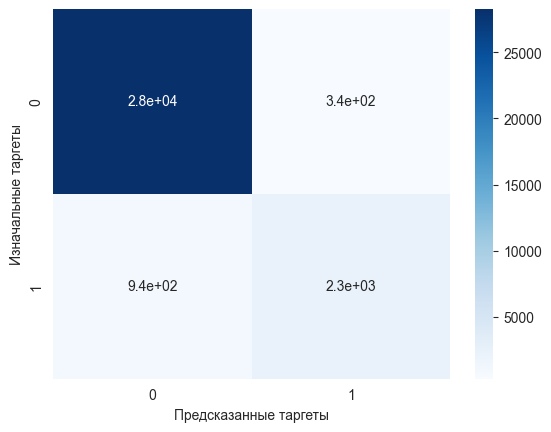

In [20]:
cm = confusion_matrix(y_test, test_predictions)
ax = sns.heatmap(cm, annot=True, cmap="Blues")
# add axis labels
ax.set_xlabel("Предсказанные таргеты")
ax.set_ylabel("Изначальные таргеты")

# display the plot
plt.show()

Логистическая регрессия хорошо себя показала и на тестовой выборке (f1 = 0.783), что можно считать успехом, так как пороговое значение f1 было 0.75

## Выводы

Суть проекта заключалась в обучении модели классификации комментариев на позитивные и негативные, чтобы помочь интернет-магазину Викишоп определять токсичные комментарии и отправлять их на модерацию. В проекте использовался набор данных с разметкой о токсичности правок.

Для выполнения проекта были выполнены следующие шаги:

Загрузка и подготовка данных:
Набор данных был загружен из файла toxic_comments.csv и был проведен первичный анализ. Для обработки текста комментариев были применены техники предобработки текста, такие как удаление лишних символов и приведение к нижнему регистру. Набор данных был разделен на обучающий и тестовый наборы.

Обучение моделей:
Для обучения моделей были использованы различные алгоритмы машинного обучения, в том числе логистическая регрессия, наивный байесовский классификатор и случайный лес.

Оценка качества моделей:
Для оценки качества моделей использовалась метрика F1-score, которая учитывает и точность, и полноту модели. Цель состояла в том, чтобы достичь F1-score не менее 0.75.

Наилучший результат (F1-score 0.783) был получен с помощью логистической регрессии.

Полученная модель может быть использована для определения токсичных комментариев в интернет-магазине Викишоп и отправки их на модерацию.